# CygnusX

In [2]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_alt.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all, convention='calabretta')
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.5)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

IOError: File not found: /user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_alt.fits

In [54]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
from bokeh.models import LogAxis, Range1d
output_notebook()

from astropy import wcs
from powspec import powspec
from wavan import fan_trans, apodize, padding, depad
from rebin import congrid
from gauss_beam import gauss_beam

Loading BokehJS ...

In [55]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

In [57]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
imzm = im - np.mean(im)

#Apodization

tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,1500,1500)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
FWHM = 12. / (60.*reso)  #Beam size
#beam = gauss_beam(FWHM,im.shape[0],im.shape[1],FWHM=True)
beam = gauss_beam(FWHM,1500,1500,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation
#Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
#del Bwt,BS11a,Bq
BS1an = BS1a / BS1a[3]

dFscl = 1400.*np.tan((1./(60.*tab_k))*(np.pi/180.))

#Plot Fourier power spectrum

xmin = 0.1
xmax = 200

Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="Scale [arcmin]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log",x_range=(xmin, xmax), tools=Tools)
f.line(1./tab_k, spec_k/spec_beamn, legend='Fourier')

#Set a list of q
q=[]
#q[0:4]=[1.4]*5
#q[5:25]=[2.5]*20
q=[2.1]*25
print q

#Wavelet power spectrum
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True)
wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=False, apodize= 0.98, arrdim = np.array([1500,1500]))

#dWscl = 1400.*np.tan((1./(60.*wav_k))*(np.pi/180.))
pcmin = 1400.*np.tan((xmin/60.)*(np.pi/180.))
pcmax = 1400.*np.tan((xmax/60.)*(np.pi/180.))

f.extra_x_ranges = {"parsec": Range1d(start=pcmin, end=pcmax)}
f.add_layout(LogAxis(x_range_name="parsec", axis_label="Scale [pc]"), 'above')

S1an = np.copy(S1a)

S1an[0,3:] = S1a[0,3:]/BS1an[3:]
S1an[1,3:] = S1a[1,3:]/BS1an[3:]
S1an[2,3:] = S1a[2,3:]/BS1an[3:]

f.diamond(1./wav_k, S1an[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(1./wav_k, S1an[1,:], legend='Coherent',color='blue',line_width=5)
f.square(1./wav_k, S1an[2,:], legend='Gaussian',color='red',line_width=5)

#Power law fit
coef,cov = np.polyfit(np.log(dWscl[7:21]),np.log(S1an[2,7:21]),deg=1,cov=True)
yfit = np.exp(coef[1])*dWscl**coef[0]

coef2,cov2 = np.polyfit(np.log(dWscl[14:21]),np.log(S1an[1,14:21]),deg=1,cov=True)
yfit2 = np.exp(coef2[1])*dWscl**coef2[0]

print "Power law Gaussian = ", coef[0], np.sqrt(np.diag(cov))
print "Power law coherent = ", coef2[0], np.sqrt(np.diag(cov2))

f.line(1./wav_k, yfit, legend='Fit', line_dash='dashed')
f.line(1./wav_k, yfit2, line_dash='dashed')

f.legend.location = "top_left"

showbok(f)

[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1]
Power law Gaussian =  3.2201261478 [ 0.02361873  0.02783371]
Power law coherent =  2.74990093882 [ 0.03008967  0.02762251]


In [10]:
#Plot Beam power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="k [arcmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools)
f.line(tab_k, spec_beamn, legend='Fourier')
f.diamond(Bwav_k, BS1an, legend='Wavelet',color='black',line_width=5)
showbok(f)

[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1]
wav_k.shape[0]= 25


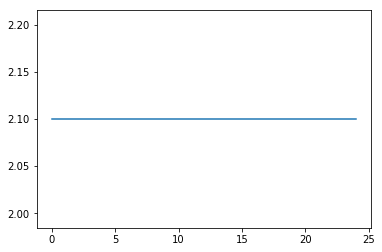

In [11]:
print q
print 'wav_k.shape[0]=',wav_k.shape[0]

x = range(25)
plot(x,np.array(q).reshape(25))

In [12]:
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_Bwav_k.npy',Bwav_k)
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_BS1a.npy',BS1a)
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_wt.npy',wt)
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_S11a.npy',S11a)
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_wav_k.npy',wav_k)
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_S1a.npy',S1a)
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_q.npy',q)

In [56]:
Bwav_k = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_Bwav_k.npy')
BS1a = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_BS1a.npy')
wt = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_wt.npy')
S11a = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_S11a.npy')
wav_k = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_wav_k.npy')
S1a = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_S1a.npy')
q = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_q.npy')

INFO: Auto-setting vmin to -9.758e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.502e+02 [aplpy.core]
INFO: Auto-setting vmin to -1.134e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.834e+02 [aplpy.core]


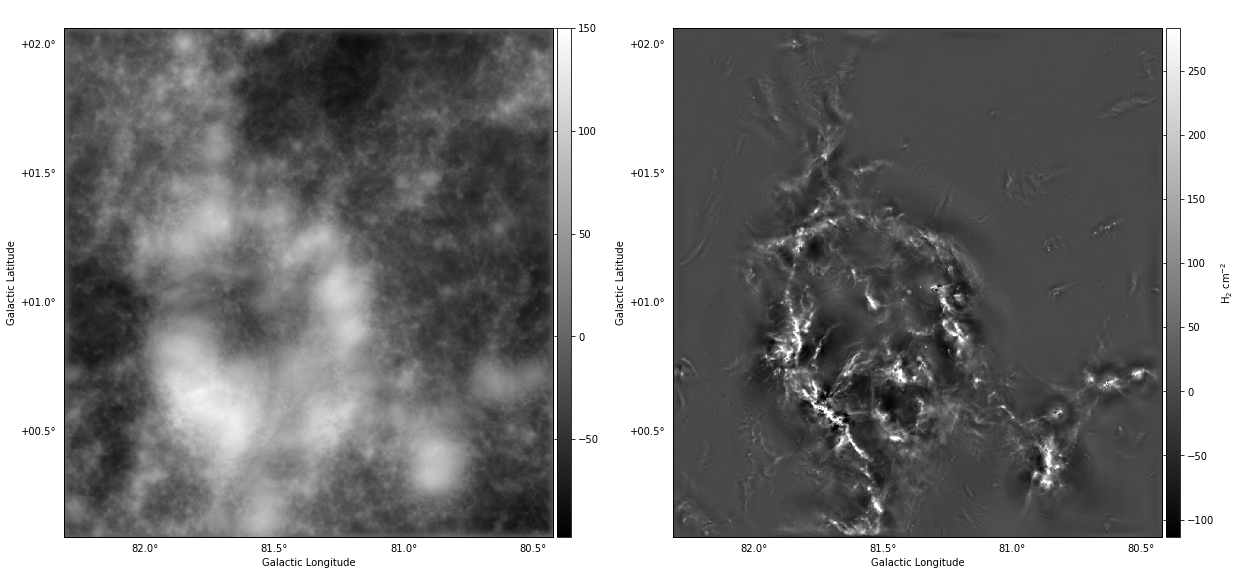

In [28]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0)#+np.sum(wt[2*M:2*M+6,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)#-np.sum(wt[2*M:2*M+6,:,:],axis=0)

fits.writeto('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_cohe.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_gaussian.fits',\
            Gaussian.real,header,overwrite=True)
fits.writeto('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_wt.fits',\
            wt.real,header,overwrite=True)

fig_all = plt.figure(1, figsize=(20,10))

figfile = '/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

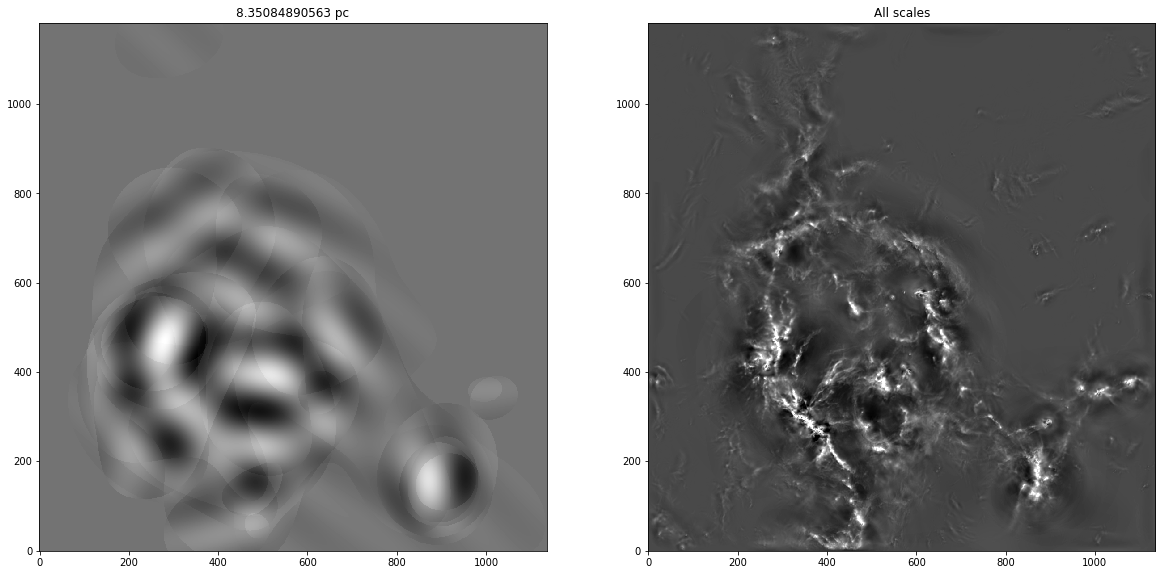

In [29]:
figure(figsize=(20,10))
plt.subplot(1,2,1)
imshow(wt[M+8,:,:].real,origin='below',cmap='gray')
plt.title(np.str(dWscl[7])+" pc")

plt.subplot(1,2,2)
imshow(np.sum(wt[M:2*M,:,:].real,axis=0),origin='below',cmap='gray', vmin=-113, vmax=283)
plt.title('All scales')

In [148]:
from wavan import gauss_segmen

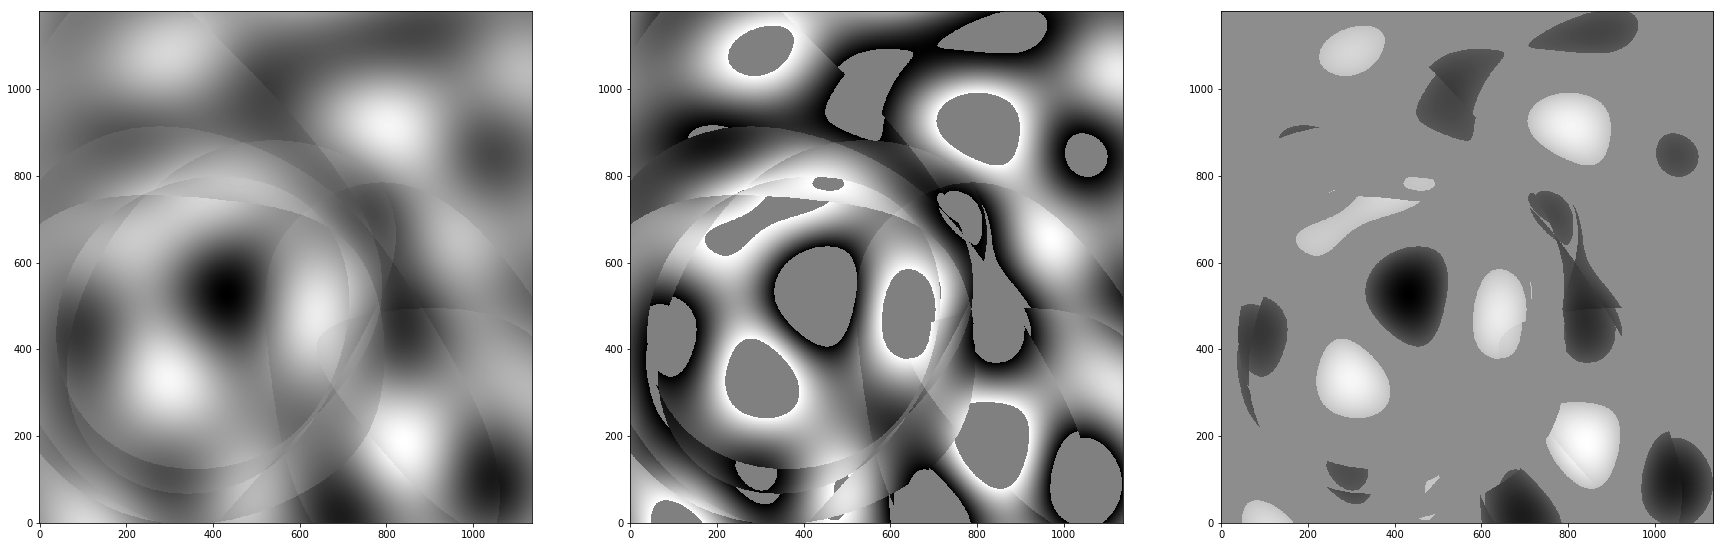

In [162]:
scale = 55
wavelet = wt[scale,:,:].real

cohe, gcoeff, q = gauss_segmen(wavelet, q=1.9, qdyn=False)

cohe_wt = np.zeros((nb,na))
gauss_wt = np.zeros((nb,na))
cohe_wt[cohe] = wavelet[cohe]
gauss_wt[gcoeff] = wavelet[gcoeff]

figure(figsize=(30,10))
plt.subplot(1,3,1)
imshow(wavelet,origin='below',cmap='gray')
plt.subplot(1,3,2)
imshow(gauss_wt,origin='below',cmap='gray')
plt.subplot(1,3,3)
imshow(cohe_wt,origin='below',cmap='gray')

## Maps mean value & negative part

Normally, the original map should be retreived with the summation of the coherent and the Gaussian part. Could the negative regions on each map be redressed by taking some signal from the other map? A mean value for each map must be derived first.

Test on a correlation analysis of both maps with the original map.

('Regression', 0.6950773368271842, -1.1137617709617098)
INFO: Auto-setting vmin to  4.878e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.746e+02 [aplpy.core]
('Regression', 0.68879992649856991, -1.4293477789598388)
INFO: Auto-setting vmin to  4.878e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.746e+02 [aplpy.core]


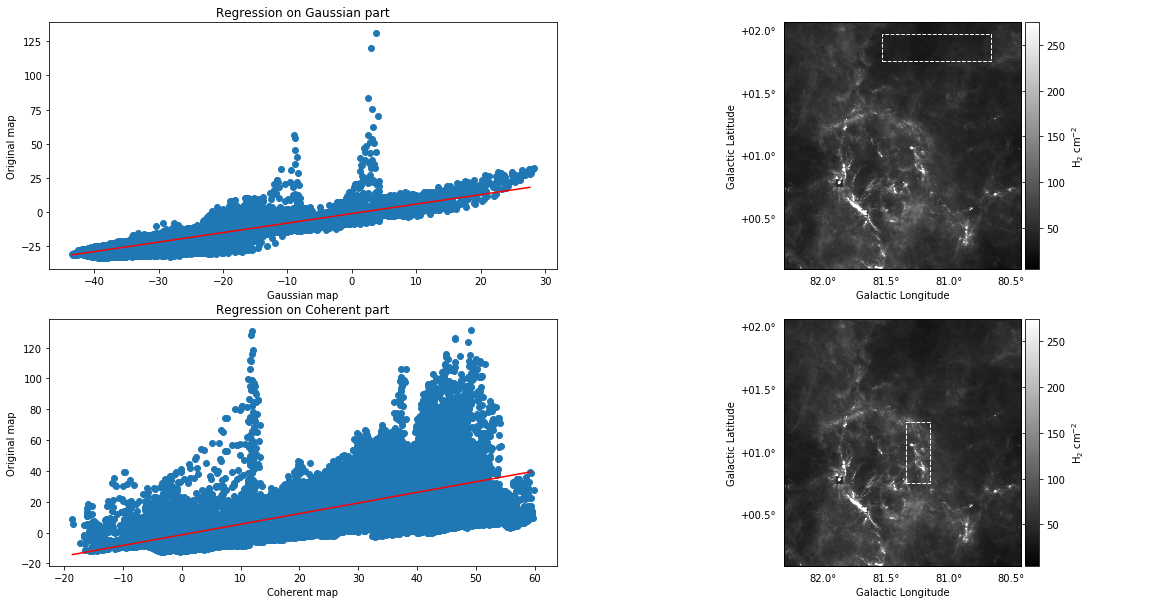

In [133]:
#Correlation analysis for a subregion of the map

#Gaussian part
x1 = 471
x2 = 992
y1 = 997
y2 = 1125

xz = (x2-x1)
yz = (y2-y1)

subim = np.zeros((xz,yz))
subGauss = np.zeros(((xz,yz)))

subim = imzm[x1:x2,y1:y2]
subGauss = Gaussian[x1:x2,y1:y2].real

(a,b) = np.polyfit(np.reshape(subGauss,(xz*yz)),np.reshape(subim,(xz*yz)),1)
xreg = np.arange(np.min(subGauss),np.max(subGauss))
yreg = a*xreg +b
print("Regression", a, b)

fig_all = plt.figure(1, figsize=(20,10))

plt.subplot(2,2,1)
scatter(subGauss, subim)
plot(xreg,yreg,'-',color= 'red')
plt.ylabel('Original map')
plt.xlabel('Gaussian map')
plt.title('Regression on Gaussian part')

figfile = '/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/CygnusX-DR21_l081_cdens_cut_nan.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.5)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

xw, yw = fig.pixel2world(x1+(x2-x1)/2.,y1+(y2-y1)/2.)

fig.show_rectangles(xw, yw, (x2-x1)*reso/60., (y2-y1)*reso/60., layer='ophiuchus', color='white', linestyle='--')

#Coherent part part
#x1 = 239
#x2 = 474
#y1 = 690
#y2 = 1080

x1 = 585
x2 = 697
y1 = 395
y2 = 688

xz = (x2-x1)
yz = (y2-y1)

subim = np.zeros((xz,yz))
subGauss = np.zeros(((xz,yz)))

subim = imzm[x1:x2,y1:y2]
subGauss = Gaussian[x1:x2,y1:y2].real

(a,b) = np.polyfit(np.reshape(subGauss,(xz*yz)),np.reshape(subim,(xz*yz)),1)
xreg = np.arange(np.min(subGauss),np.max(subGauss))
yreg = a*xreg +b
print("Regression", a, b)

plt.subplot(2,2,3)
scatter(subGauss, subim)
plot(xreg,yreg,'-',color= 'red')
plt.ylabel('Original map')
plt.xlabel('Coherent map')
plt.title('Regression on Coherent part')

figfile = '/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/CygnusX-DR21_l081_cdens_cut_nan.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all, convention='calabretta',subplot=(2, 2, 4))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.5)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

xw, yw = fig.pixel2world(x1+(x2-x1)/2.,y1+(y2-y1)/2.)

fig.show_rectangles(xw, yw, (x2-x1)*reso/60., (y2-y1)*reso/60., layer='ophiuchus', color='white', linestyle='--')

We need to do a proper partial correlation or an inversion of the model which could also correct the reconstructed maps.

In [134]:
#x1 = 471
#x2 = 992
#y1 = 997
#y2 = 1125

x1 = 585
x2 = 697
y1 = 395
y2 = 688

xz = (x2-x1)
yz = (y2-y1)

vtot = np.reshape(imzm[x1:x2,y1:y2],(xz*yz))
vgauss = np.reshape(Gaussian[x1:x2,y1:y2].real,(xz*yz))
vcohe = np.reshape(coherent[x1:x2,y1:y2].real,(xz*yz))

mA = np.zeros((xz*yz,2))

#vtot = np.reshape(imzm[x1:x2,y1:y2],(na*nb))
#vgauss = np.reshape(Gaussian.real,(na*nb))
#vcohe = np.reshape(coherent.real,(na*nb))

#mA = np.zeros((na*nb,2))

mA[:,0] = vgauss
mA[:,1] = vcohe

cov_mat = np.dot(np.transpose(mA),mA)
beta_mat = np.dot(np.transpose(mA),np.transpose(vtot))

inversion = np.dot(np.linalg.inv(cov_mat),beta_mat)

print inversion

[ 0.69947849  0.67339832]


Equivalent to a partial correlation, where the Gaussian and coherent parts are partially correlated

In [ ]:
from stats import covar

In [83]:
H1 = (np.var(coherent.real)*covar(Gaussian.real,im) - covar(Gaussian.real,coherent.real)*covar(coherent.real,im))/\
      (np.var(Gaussian.real)*np.var(coherent.real)-np.abs(covar(Gaussian.real,coherent.real))**2)
print H1

H2 = (np.var(Gaussian.real)*covar(coherent.real,im) - covar(coherent.real,Gaussian.real)*covar(Gaussian.real,im))/\
      (np.var(Gaussian.real)*np.var(coherent.real)-np.abs(covar(Gaussian.real,coherent.real))**2)
print H2

0.712158043028
0.686360880454


New corrected fragmented maps...

INFO: Auto-setting vmin to  1.521e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.029e+02 [aplpy.core]
INFO: Auto-setting vmin to -6.769e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.670e+02 [aplpy.core]


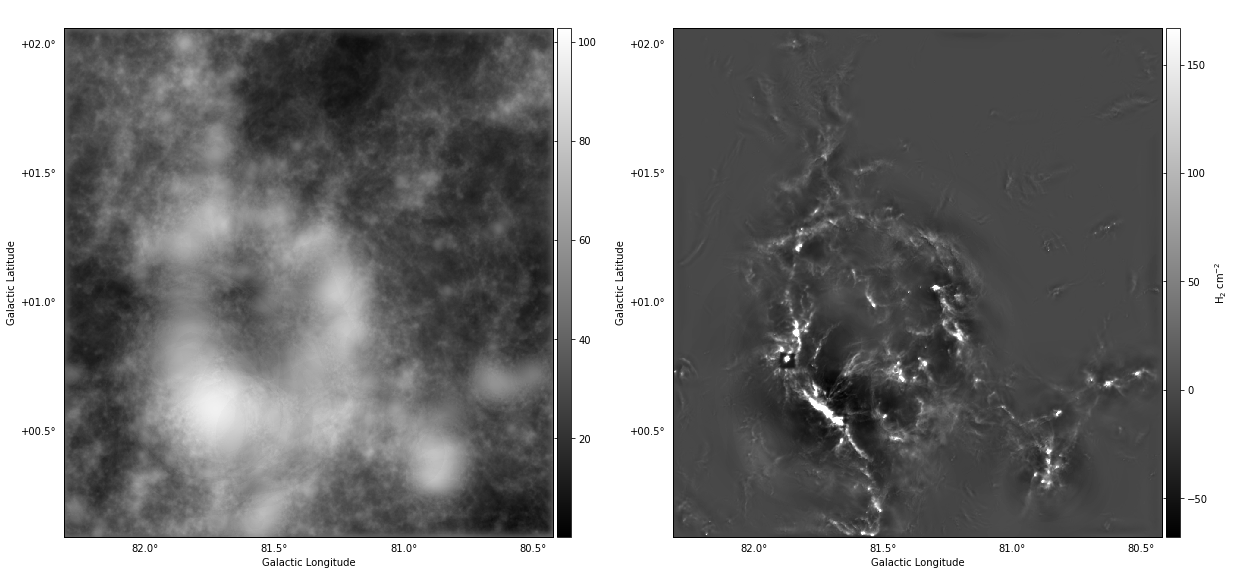

In [175]:
c_Gauss = (Gaussian.real + np.mean(im)) * 0.68 - 1.11
c_cohe = coherent.real  * 0.69 -1.43

fits.writeto('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_cohe_corr.fits',\
            c_cohe,header,overwrite=True)
fits.writeto('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_gaussian_corr.fits',\
            c_Gauss,header,overwrite=True)
fits.writeto('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_tot.fits',\
            c_Gauss+c_cohe,header,overwrite=True)

fig_all = plt.figure(1, figsize=(20,10))

figfile = '/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_gaussian_corr.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_cohe_corr.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

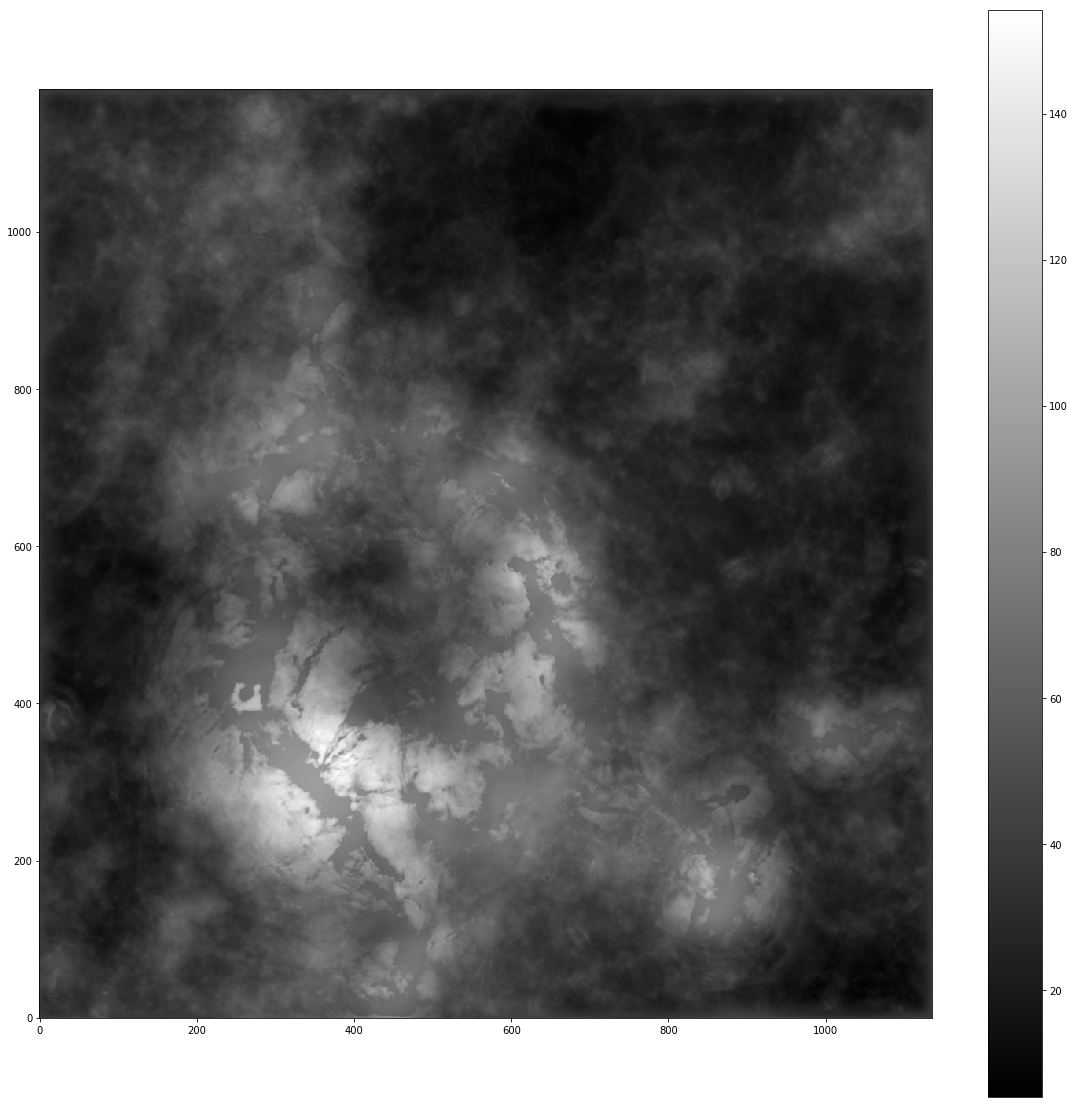

In [144]:
neg = np.where(c_cohe < 0.)
buff = np.zeros((nb,na))
buff[neg] = c_cohe[neg]

red_Gauss = np.copy(c_Gauss)

red_Gauss -= buff
figure(figsize=(20,20))
imshow(red_Gauss, origin='below', cmap='gray')
plt.colorbar()

fits.writeto('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_gaussian_corr.fits',\
            red_Gauss,header,overwrite=True)

In [1]:
fig, axs = plt.subplots(M,3,figsize=(12,70))

axs = axs.ravel()
fig.tight_layout()

for i in range(M):
    
    if np.mean(S11a[M+i,:,:]) !=0:
        wc = (S11a[M+i,:,:])/np.mean(S11a[M+i,:,:])
    else:
        wc = np.zeros((im.shape[0],im.shape[1]))
    wo = (S11a[i,:,:])/np.mean(S11a[i,:,:])
    #wg = (S11a[2*M+i,0:100 & 700:,:])/np.mean(S11a[2*M+i,:,:])
    #wg = (S11a[2*M+i,100:700,:])/np.mean(S11a[2*M+i,:,:])
    wg = (S11a[2*M+i,:,:])/np.mean(S11a[2*M+i,:,:])
    
    #Number of independent points
    npix = np.int((im.shape[0] * wav_k[i]*reso)**2.)
    if npix == 0: nbins=1
    if npix > 0 & npix < 50 : nbins=npix
    if npix > 50 : nbins=50
    
    histo, edges = np.histogram(wo,bins=nbins)
    histo_c, edges = np.histogram(wc[wc != 0.],bins=nbins)
    histo_g, edges = np.histogram(wg[wg != 0.],bins=nbins)
    
    axs[i*3].bar(edges[:-1], histo, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
    axs[i*3].set_title('Scale '+np.str(i))
    axs[i*3].set_yscale('log')
    
    axs[i*3+1].bar(edges[:-1], histo_g, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
    axs[i*3+1].set_ylim((0,np.max(histo_g)))
    
    axs[i*3+2].bar(edges[:-1], histo_c, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7')
    axs[i*3+2].set_yscale('log')

NameError: name 'plt' is not defined

In [16]:
from gaussfit import *

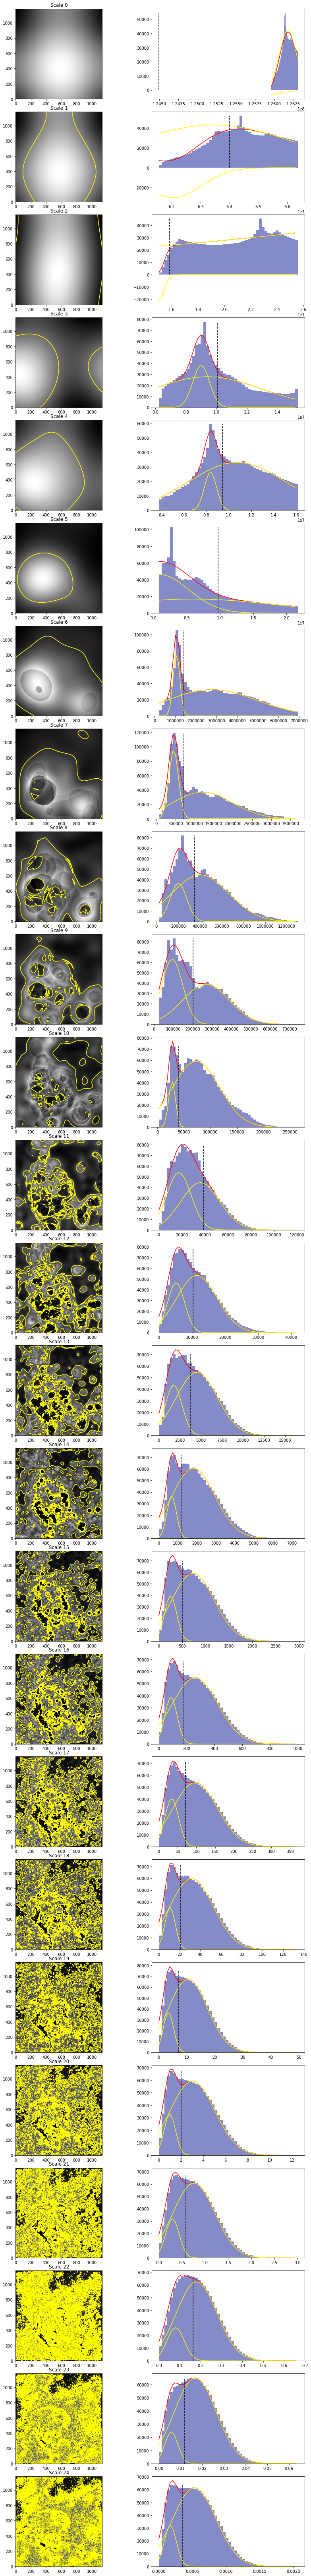

In [58]:
spec_subg1 = np.zeros(M)
spec_subg2 = np.zeros(M)

wt_subg1 = np.zeros((M,nb,na),dtype=complex)
wt_subg2 = np.zeros((M,nb,na),dtype=complex)
buffer = np.zeros((nb,na),dtype=complex)

fig, axs = plt.subplots(M,2,figsize=(12,90))

axs = axs.ravel()
fig.tight_layout()

for i in range(M):
    wg = (S11a[2*M+i,:,:])#/np.mean(S11a[2*M+i,:,:])
    histo_g, edges = np.histogram(wg[wg != 0.],bins=nbins)
    
    #Gaussian fit
    params = []
    params.append([5e4, 0.6*np.mean(S11a[2*M+i,:,:]), 0.1*np.mean(S11a[2*M+i,:,:])])
    params.append([3e4, 1.50*np.mean(S11a[2*M+i,:,:]), 0.3*np.mean(S11a[2*M+i,:,:])])
    #params.append([2.6e4, 1.25, 1.5])
    
    fit = gaussfit(edges[:-1], histo_g, params)

    nbpar=len(fit[0])/3
    newpar=fit[0].reshape((nbpar,3))
    
    #Set limit of 2 sigma above the first Gaussian
    limit = newpar[p,1]+ 2.* np.abs(newpar[p,2])
    
    wtg = wt[2*M+i,:,:]
    S11g = S11a[2*M+i,:,:]
    
    #Find coefficients position
    subg1 = np.where(S11g <= limit)
    subg2 = np.where(S11g > limit)
    
    #Create subsets of coefficients and power spectra
    buffer[subg1] = wtg[subg1]
    wt_subg1[i,:,:] = buffer
    spec_subg1[i] = np.sum(S11g[subg1])/1500.**2.
    
    buffer *= 0.
    buffer[subg2] = wtg[subg2]
    wt_subg2[i,:,:] = buffer
    spec_subg2[i] = np.sum(S11g[subg2])/1500.**2.
    
    buffer *= 0.
    
    #Plot
    p=0
    axs[i*2].imshow(wg,origin='below',cmap='gray')
    axs[i*2].contour(wg,[limit],colors='yellow')
    axs[i*2].set_title('Scale '+np.str(i))
    
    axs[i*2+1].bar(edges[:-1], histo_g, width=np.diff(edges), align="edge",edgecolor='none',facecolor='#858bc7',label='PDF')
    axs[i*2+1].plot(edges[:-1], multi_gaussians(edges[:-1], fit[0]),color='red',linewidth=1.5,label='multi-fit')
    for j in range(nbpar):
        axs[i*2+1].plot(edges[:-1], gaussian(edges[:-1], newpar[j,0], newpar[j,1], newpar[j,2]),color='yellow',linewidth=1.5,label='Gaussians')
    axs[i*2+1].plot([limit,limit],[0,np.max(histo_g)],color='black',linestyle='dashed',linewidth=1.5,label='limit contour')


In [61]:
#Plot Fourier power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="k [arcmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools)
f.line(tab_k, spec_k/spec_beamn, legend='Fourier')

f.square(wav_k[6:], spec_subg1[6:]/BS1an[6:], legend='Random',color='red',line_width=5)
f.circle(wav_k[6:], spec_subg2[6:]/BS1an[6:], legend='Intermit',color='green',line_width=5)
f.triangle(wav_k, S1an[1,:], legend='Coherent',color='blue',line_width=5)

#Power law fit
#coef = np.polyfit(np.log(wav_k[7:21]),np.log(S1an[2,7:21]),deg=1)
#yfit = np.exp(coef[1])*wav_k**coef[0]

#coef2 = np.polyfit(np.log(wav_k[14:21]),np.log(S1an[1,14:21]),deg=1)
#yfit2 = np.exp(coef2[1])*wav_k**coef2[0]

#print "Power law = ", coef[0],coef2[0]

#f.line(wav_k, yfit, legend='Fit', line_dash='dashed')
#f.line(wav_k, yfit2, line_dash='dashed')

showbok(f)

INFO: Auto-setting vmin to -9.635e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.487e+02 [aplpy.core]
INFO: Auto-setting vmin to -9.473e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.488e+02 [aplpy.core]


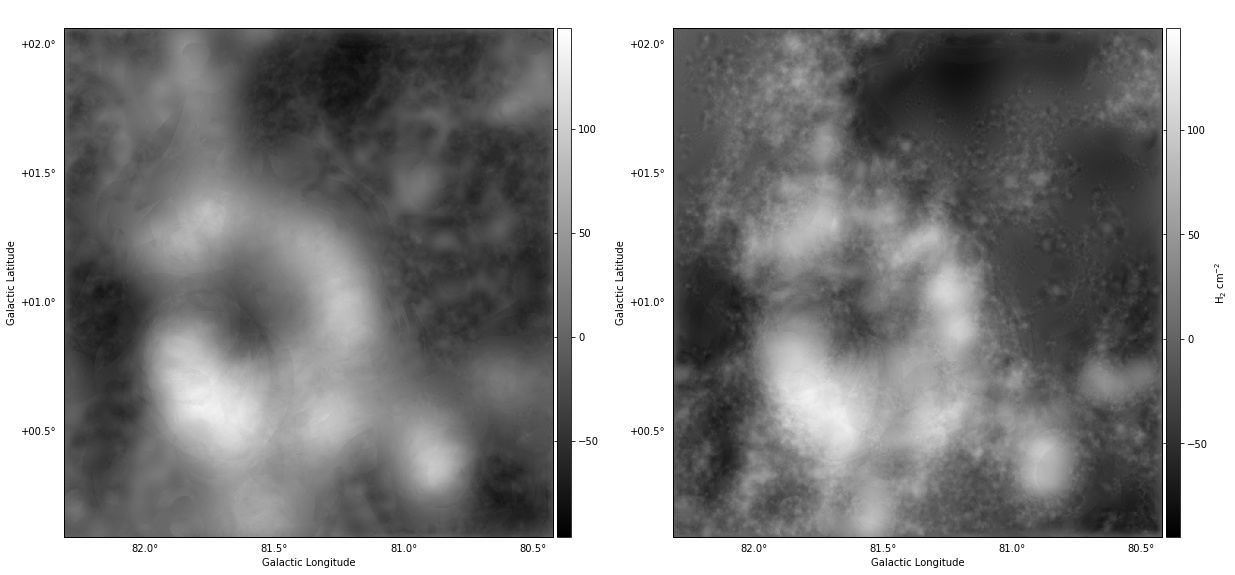

In [56]:
start = 8

im_subg1 = np.sum(wt_subg1[start:,:,:],axis=0) + np.mean(im)
im_subg2 = np.sum(wt_subg2[start:,:,:],axis=0) + np.mean(im)

im_subg1 += np.sum(wt[2*M:2*M+start,:,:],axis=0)
im_subg2 += np.sum(wt[2*M:2*M+start,:,:],axis=0)

fits.writeto('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_subg1.fits',\
            im_subg1.real,header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_subg2.fits',\
            im_subg2.real,header,overwrite=True)

fig_all = plt.figure(1, figsize=(20,10))

figfile = '/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_subg1.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_subg2.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

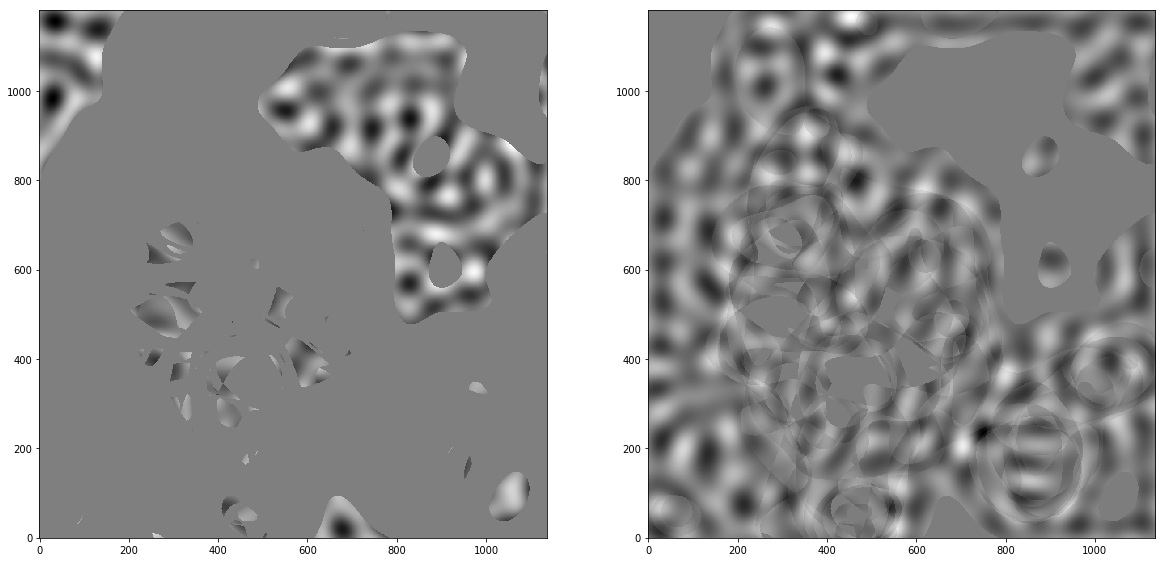

In [57]:
scale = 10
fig_all = plt.figure(1, figsize=(20,10))
plt.subplot(1,2,1)
imshow(wt_subg1[scale,:,:].real,origin='below',cmap='gray')
plt.subplot(1,2,2)
imshow(wt_subg2[scale,:,:].real,origin='below',cmap='gray')